In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from sklearn.metrics import classification_report
from transformers import TOKENIZER_MAPPING, AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import os
from dataset import Dataset
import pandas as pd

In [2]:
TOKENIZER_NAME = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
MODEL_NAME = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
LEARNING_RATE = 3e-5

EPOCHS = 4
BATCH_SIZE = 24 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())    
    print(f'We will use the GPU:{torch.cuda.get_device_name()} ({device})')

else:
    print('NO GPU AVAILABLE ERROR')
    device = torch.device("cpu")
   
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model = AutoModelForSequenceClassification.from_pretrained("../../task_a/pickles_tam/", num_labels=5, output_attentions=True)

model.to(device)
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, no_deprecation_warning=True)

data = Dataset()
#eng_train, eng_val, tam_train, tam_val, mal_train, mal_val, eng_tam_train, eng_tam_val
_, _,datatrain, _, _, _, _, _ = data.get_phobia_dataset(tokenizer, balance=False)
#_,_, kan_train_2022, _, _,_ = data.get_fire_2022_dataset(tokenizer, balance=False)

train_dataloader = DataLoader(
            datatrain,
            sampler = RandomSampler(datatrain),
            batch_size = BATCH_SIZE)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


There are 1 GPU(s) available.
We will use the GPU:Tesla V100-SXM2-32GB (cuda)


In [3]:
def correlation_validation(model, tokenizer, device, BS=16):
    vbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))

    model.eval()
    
    true_labels = []
    pred_labels = []
    
    # Label names: Index(['Mixed_feelings', 'Negative', 'Positive', 'not-Tamil', 'unknown_state']
    # Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic']
    datalist = []
    for step, batch in vbar:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad(): 
            outputs = model(input_ids=b_input_ids, attention_mask=b_masks,
                                            labels=b_labels)
            probs = torch.softmax(outputs.logits, axis=1).detach().cpu().numpy().tolist() 
            logits = outputs.logits.detach().cpu().numpy().tolist()
            label_ids = b_labels.to('cpu').numpy().tolist()
            
            true_labels.extend(label_ids)
            
            for i in range(len(logits)):
                if probs[i][2] > probs[i][3]:
                    datalist.append([label_ids[i], probs[i][0], probs[i][1], probs[i][2], probs[i][3], probs[i][4], 0])
                else:
                    datalist.append([label_ids[i], probs[i][0], probs[i][1], probs[i][2], probs[i][3], probs[i][4], 1])

    model.train()
    return datalist

In [4]:
d = correlation_validation(model, tokenizer, device)

100%|██████████| 73/73 [00:17<00:00,  4.23it/s]


In [5]:
newpd = pd.DataFrame(d)
newpd

,0,1,2,3,4,5,6
0,1,0.001743,0.000927,0.982878,0.000386,0.014067,0
1,1,0.436941,0.161424,0.148332,0.000852,0.252451,0
2,0,0.837612,0.105739,0.026114,0.001101,0.029434,0
3,0,0.206025,0.005352,0.277507,0.000689,0.510428,0
4,0,0.938200,0.026866,0.006948,0.001514,0.026472,0
...,...,...,...,...,...,...,...
1745,1,0.006969,0.002030,0.979069,0.001601,0.010330,0
1746,1,0.019137,0.002751,0.940119,0.000235,0.037758,0
1747,1,0.004423,0.000706,0.970723,0.004667,0.019481,0
1748,1,0.006446,0.016702,0.007350,0.003177,0.966325,0


In [13]:
from scipy.stats import ttest_ind
print(f"TAMIL NEGATIVE SENTIMENT non homophobic vs homophobic{ttest_ind(newpd[newpd[0]==0][2], newpd[newpd[0]==1][2])}")
print(f"TAMIL POSITIVE SENTIMENT non homophobic vs homophobic{ttest_ind(newpd[newpd[0]==0][3], newpd[newpd[0]==1][3])}")
print(f"TAMIL MIXED SENTIMENT non homophobic vs homophobic{ttest_ind(newpd[newpd[0]==0][1], newpd[newpd[0]==1][1])}")

TAMIL NEGATIVE SENTIMENT non homophobic vs homophobicTtest_indResult(statistic=5.692608483835361, pvalue=1.4778816000689864e-08)
TAMIL POSITIVE SENTIMENT non homophobic vs homophobicTtest_indResult(statistic=-12.673140660495015, pvalue=3.42434912790214e-35)
TAMIL MIXED SENTIMENT non homophobic vs homophobicTtest_indResult(statistic=12.226293166384643, pvalue=5.71826896581604e-33)


In [7]:
newpd[newpd[0]==1].value_counts()

0  1         2         3         4         5         6
1  0.421857  0.004467  0.350260  0.003318  0.220099  0    2
   0.926473  0.009841  0.035570  0.000711  0.027404  0    1
   0.013587  0.014769  0.777000  0.000332  0.194313  0    1
   0.013399  0.005280  0.869078  0.002344  0.109899  0    1
   0.013414  0.006223  0.145877  0.000844  0.833642  0    1
                                                         ..
   0.111456  0.001722  0.662145  0.007274  0.217404  0    1
   0.112921  0.030405  0.074071  0.005378  0.777225  0    1
   0.113452  0.004544  0.069859  0.006196  0.805949  0    1
   0.113861  0.011379  0.366669  0.000484  0.507607  0    1
   0.000885  0.002895  0.003363  0.039725  0.953133  1    1
Length: 1337, dtype: int64

In [8]:
corr = newpd[[0,6]]
corr

,0,6
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0
...,...,...
1745,1,0
1746,1,0
1747,1,0
1748,1,0


In [9]:
from scipy.stats import ttest_ind
corr.corr(method='pearson')

,0,6
0,1.000000,0.027759
6,0.027759,1.000000


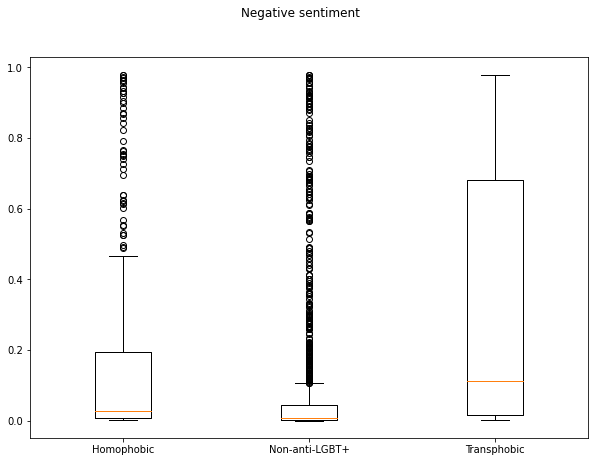

In [10]:
import matplotlib.pyplot as plt

homo = newpd[newpd[0]==0][2]
non = newpd[newpd[0]==1][2]
trans = newpd[newpd[0]==2][2] 

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot([homo,non,trans])
fig.suptitle('Negative sentiment')
ax.set_xticklabels(['Homophobic', 'Non-anti-LGBT+', 'Transphobic'])
fig.savefig('negative-sentiment-tam.jpg')

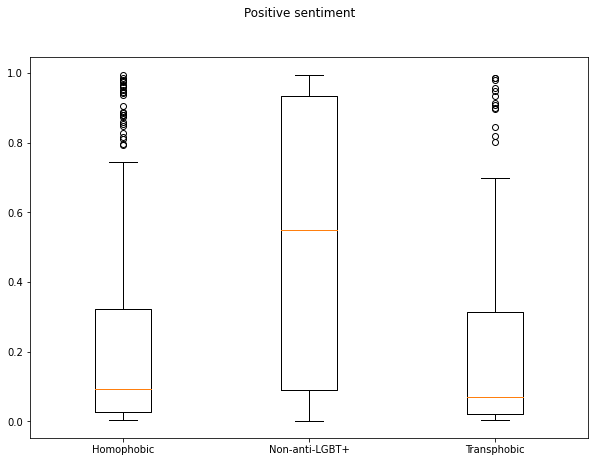

In [11]:
homo = newpd[newpd[0]==0][3]
non = newpd[newpd[0]==1][3]
trans = newpd[newpd[0]==2][3] 

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot([homo,non,trans])
fig.suptitle('Positive sentiment')
ax.set_xticklabels(['Homophobic', 'Non-anti-LGBT+', 'Transphobic'])
fig.savefig('positive-sentiment-tam.jpg')

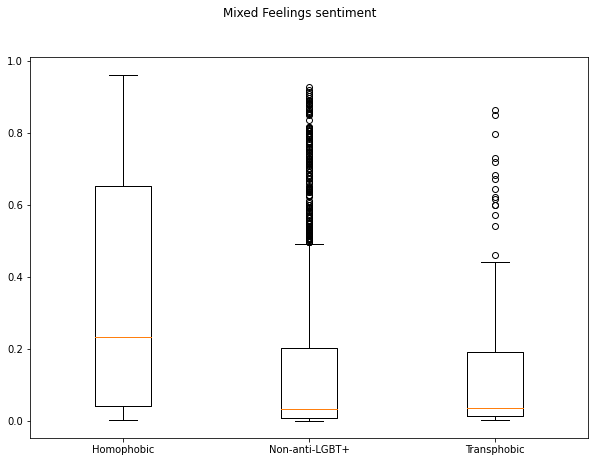

In [12]:
homo = newpd[newpd[0]==0][1]
non = newpd[newpd[0]==1][1]
trans = newpd[newpd[0]==2][1] 

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot([homo,non,trans])
fig.suptitle('Mixed Feelings sentiment')
ax.set_xticklabels(['Homophobic', 'Non-anti-LGBT+', 'Transphobic'])
fig.savefig('mixed_feelings-sentiment-tam.jpg')